In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from time import time
from pandas import DataFrame
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import shap

from ipywidgets import interact
from data_preprocessing import load_data, preprocess_data, split_data
from feature_engineering import feature_engineering
from model_training import train_model
from model_evaluation import evaluate_model
from model_inference import predict_churn
from utils import display_correlation_matrix, display_confusion_matrix, display_precision_recall_curve, \
    display_roc_curve, save_model, save_decision_threshold, create_model

if not os.path.exists('./models'):
    os.mkdir('./models')

## Загрузка данных

In [3]:
df = load_data('./data/Bank Customer Churn Prediction copy.csv')
df

customer_id  credit_score  country  gender   age  tenure    balance  \
0        15634602           619   France  Female   NaN       2       0.00   
1        15647311           608    Spain  Female  41.0       1   83807.86   
2        15619304           502   France  Female  42.0       8  159660.80   
3        15701354           699   France  Female  39.0       1       0.00   
4        15737888           850    Spain  Female  43.0       2  125510.82   
...           ...           ...      ...     ...   ...     ...        ...   
9995     15606229           771   France    Male  39.0       5       0.00   
9996     15569892           516   France    Male  35.0      10   57369.61   
9997     15584532           709   France  Female  36.0       7       0.00   
9998     15682355           772  Germany    Male  42.0       3   75075.31   
9999     15628319           792   France  Female  28.0       4  130142.79   

      products_number  credit_card  active_member  estimated_salary  churn  
0                   1            1              1         101348.88      1  
1                   1            0              1         112542.58      0  
2                   3            1              0         113931.57      1  
3                   2            0              0          93826.63      0  
4                   1            1              1          79084.10      0  
...               ...          ...            ...               ...    ...  
9995                2            1              0          96270.64      0  
9996                1            1              1         101699.77      0  
9997                1            0              1          42085.58      1  
9998                2            1              0          92888.52      1  
9999                1            1              0          38190.78      0  

[10000 rows x 12 columns]

## Предварительная обработка данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           9999 non-null   object 
 3   gender            9999 non-null   object 
 4   age               9998 non-null   float64
 5   tenure            10000 non-null  int64  
 6   balance           9999 non-null   float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


In [5]:
# посмотрим на признаки Пол и Страна, которые должны быть закодированы в числовой формат
print(df['gender'].unique())
print(df['country'].unique())

['Female' 'Male' nan]
['France' 'Spain' 'Germany' nan]


In [6]:
# препроцессинг данных
df = preprocess_data(df)

df.sample(5)

credit_score  country  gender   age  tenure    balance  products_number  \
3090           734        2       2  43.0       3   55853.33                2   
1604           718        1       2  31.0       1  152663.77                1   
4217           587        3       1  35.0       5  121863.61                1   
7115           673        1       2  42.0       4       0.00                2   
1986           845        3       2  41.0       2   81733.74                2   

      credit_card  active_member  estimated_salary  churn  
3090            0              1          94811.85      1  
1604            0              1          17128.64      0  
4217            1              1          23481.69      1  
7115            1              0         121440.80      0  
1986            0              0         199761.29      0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  int16  
 2   gender            10000 non-null  int16  
 3   age               10000 non-null  float64
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(3), int16(2), int64(6)
memory usage: 742.3 KB


## Предварительный анализ данных

In [8]:
df.describe()

credit_score       country        gender          age        tenure  \
count  10000.000000  10000.000000  10000.000000  10000.00000  10000.000000   
mean     650.528800      1.749500      1.454300     38.92050      5.012800   
std       96.653299      0.830433      0.497932     10.48762      2.892174   
min      350.000000      1.000000      1.000000     18.00000      0.000000   
25%      584.000000      1.000000      1.000000     32.00000      3.000000   
50%      652.000000      1.000000      1.000000     37.00000      5.000000   
75%      718.000000      3.000000      2.000000     44.00000      7.000000   
max      850.000000      3.000000      2.000000     92.00000     10.000000   

             balance  products_number  credit_card  active_member  \
count   10000.000000     10000.000000  10000.00000   10000.000000   
mean    76487.078964         1.530200      0.70550       0.515100   
std     62397.686905         0.581654      0.45584       0.499797   
min         0.000000         1.000000      0.00000       0.000000   
25%         0.000000         1.000000      0.00000       0.000000   
50%     97208.460000         1.000000      1.00000       1.000000   
75%    127644.240000         2.000000      1.00000       1.000000   
max    250898.090000         4.000000      1.00000       1.000000   

       estimated_salary         churn  
count      10000.000000  10000.000000  
mean      100090.239881      0.203700  
std        57510.492818      0.402769  
min           11.580000      0.000000  
25%        51002.110000      0.000000  
50%       100193.915000      0.000000  
75%       149388.247500      0.000000  
max       199992.480000      1.000000

### Обзорный просмотр признаков и их связи с целью

In [9]:
dims = df.columns.values[:-1]

fig = px.scatter_matrix(df,
                        dimensions=dims,
                        color="churn", 
                        labels={col:col.replace('_', ' ').capitalize() for col in dims})

fig.update_layout(title="Матрица признаков",
                  dragmode='select', 
                  width=1300, 
                  height=1300, 
                  hovermode='closest')
fig.show()

Анализируя представленные выше графики, можно предположить связи конкретных признаков с оттоком.

Например:
* малый кредитный рейтинг влияет на отток
* проживание в Германии (независимо от пола)
* возраст (примерно от 41 до 57) при любом кредитном рейтинге
* большое кол-во банковских продуктов при любом кредитном рейтинге
* низкий кредитный рейтинг при любой предполагаемой средней зарплате
* возраст (примерно от 41 до 57) при любом стаже (tenure)
* возраст (примерно от 41 до 57) при любом балансе
* наличие или отсутствие кредитной карты не влияет на отток
* активность практически не влияет на отток


### Матрица коэффициентов корреляции Пирсона

In [10]:
display_correlation_matrix(df.corr())


In [11]:
display_correlation_matrix(df.corr(method='spearman'), 'Матрица корреляции (Спирмана)')


Анализируя представленные матрицы корреляции, можно предположить что существует небольшая линейная зависимость:

* между страной проживания и оттоком
* между половой принадлежностью и оттоком (женщины более подвержены оттоку?)
* между возрастом и оттоком
* между кол-вом банковских продуктов и балансом (отрицательная зависимость: больше продуктов - меньше баланс)
* между балансом и страной проживания


### Детальный обзор признаков

In [12]:
for feat in df.columns.values:
    fig = px.histogram(df, x=feat, color="churn", marginal='box')

    fig.update_layout(title=f"{feat.replace('_', ' ').capitalize()}",
                      bargap = 0.2,
                      dragmode='select', 
                      width=800, 
                      height=400, 
                      hovermode='closest',
                      template='seaborn')
    fig.show()

По результатам детального осмотра признаков предлагаю разбить значения некоторых признаков на группы:

* Баланса: '<38000', '38000-132000', '>132000'

* Возраста: '<31', '31-38', '38-41', '41-51' '>51' 

## Разбивка датасета на тренировочную и тестовую части

In [13]:
X_train, X_test, y_train, y_test = split_data(df, 'churn')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 10), (2000, 10), (8000,), (2000,))

## Создание новых признаков

In [14]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

X_train.sample(5)

credit_score  country  gender   age  tenure    balance  products_number  \
5826           509        3       2  29.0       0  107712.57                2   
9861           544        1       1  38.0       8       0.00                1   
4647           781        1       2  28.0       4       0.00                2   
1124           606        2       1  35.0       7       0.00                1   
827            758        2       1  56.0       1       0.00                2   

      credit_card  active_member  estimated_salary  balance_group  age_group  
5826            1              1          92898.17              2          1  
9861            1              1          98208.62              1          2  
4647            1              0         177703.15              1          1  
1124            1              0         106837.06              1          2  
827             1              1          10643.38              1          5

## Выбор классификатора

Построим моедели с использованием различных классификаторв с парамнтрами по умолчанию и оценим точность и скорость работы.

In [15]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


# составим список классификаторов
classifiers = []

classifiers.append(("LogisticRegression (solver='lbfgs')", 
                    LogisticRegression(solver='lbfgs', random_state=100, verbose=0)))

classifiers.append(("LogisticRegression (solver='liblinear')", 
                    LogisticRegression(solver='liblinear', random_state=100, verbose=0)))

classifiers.append(("XGBClassifier (booster='gbtree')",
                    XGBClassifier(booster='gbtree', random_state=100)))

classifiers.append(("XGBClassifier (booster='gblinear')",
                    XGBClassifier(booster='gblinear', random_state=100)))

classifiers.append(("SVC (kernel='rbf')", 
                    SVC(kernel='rbf', random_state=100)))

classifiers.append(("SVC (kernel='linear')", 
                    SVC(kernel='linear', random_state=100)))

classifiers.append(("SVC (kernel='poly')", 
                    SVC(kernel='poly', degree=3, random_state=100)))

classifiers.append(("SVC (kernel='sigmoid')", 
                    SVC(kernel='sigmoid', random_state=100)))

classifiers.append(("GaussianNB", 
                    GaussianNB()))

classifiers.append(("RandomForestClassifier (criterion='gini')", 
                    RandomForestClassifier(criterion='gini', random_state=100)))

classifiers.append(("RandomForestClassifier (criterion='entropy')", 
                    RandomForestClassifier(criterion='entropy', random_state=100)))

classifiers.append(("KNeighborsClassifier (algorithm='brute')", 
                    KNeighborsClassifier(algorithm='brute')))

classifiers.append(("KNeighborsClassifier (algorithm='ball_tree')", 
                    KNeighborsClassifier(algorithm='ball_tree')))

classifiers.append(("KNeighborsClassifier (algorithm='kd_tree')", 
                    KNeighborsClassifier(algorithm='kd_tree')))

classifiers.append(("DecisionTreeClassifier (criterion='entropy')", 
                    DecisionTreeClassifier(criterion='entropy', random_state=100)))

classifiers.append(("DecisionTreeClassifier (criterion='gini')", 
                    DecisionTreeClassifier(criterion='gini', random_state=100)))


In [16]:
# признаки
features = {
    'numeric': ['credit_score', 'tenure', 'estimated_salary'],
    'category': ['country', 'gender', 'age_group', 'balance_group', 'products_number', 'credit_card', 'active_member'],
    }

results = []

for name, clf in classifiers:
    model = create_model(clf, features)
    start_time = time()
    model, _ = train_model(model, X_train, y_train, use_gs=False)
    train_scores = cross_val_score(model, X_train, y_train, cv=5).mean()
    test_scores = cross_val_score(model, X_test, y_test, cv=5).mean()
    took = time() - start_time
    print(f"Classifier: {name}, "
          f"train score: {train_scores: 0.4f}, "
          f"test score: {test_scores: 0.4f}, "
          f"took: {took}")

    results.append({'name': name, 'train_score': train_scores, 'test_score': test_scores, 'took': took})

results_df = DataFrame(results).sort_values(by=['test_score', 'took'], ascending=False)
results_df

Classifier: LogisticRegression (solver='lbfgs'), train score:  0.8518, test score:  0.8535, took: 0.28544092178344727
Classifier: LogisticRegression (solver='liblinear'), train score:  0.8519, test score:  0.8535, took: 0.2895817756652832
Classifier: XGBClassifier (booster='gbtree'), train score:  0.8444, test score:  0.8355, took: 1.092409610748291
Classifier: XGBClassifier (booster='gblinear'), train score:  0.8518, test score:  0.8545, took: 1.010545015335083
Classifier: SVC (kernel='rbf'), train score:  0.8578, test score:  0.8530, took: 7.348851919174194
Classifier: SVC (kernel='linear'), train score:  0.8367, test score:  0.8370, took: 5.72411036491394
Classifier: SVC (kernel='poly'), train score:  0.8596, test score:  0.8530, took: 7.684711217880249
Classifier: SVC (kernel='sigmoid'), train score:  0.7428, test score:  0.7645, took: 6.179290533065796
Classifier: GaussianNB, train score:  0.8191, test score:  0.8220, took: 0.18429017066955566
Classifier: RandomForestClassifier (c

name  train_score  test_score  \
9      RandomForestClassifier (criterion='gini')     0.845750      0.8575   
3             XGBClassifier (booster='gblinear')     0.851750      0.8545   
1        LogisticRegression (solver='liblinear')     0.851875      0.8535   
0            LogisticRegression (solver='lbfgs')     0.851750      0.8535   
10  RandomForestClassifier (criterion='entropy')     0.849375      0.8530   
6                            SVC (kernel='poly')     0.859625      0.8530   
4                             SVC (kernel='rbf')     0.857750      0.8530   
5                          SVC (kernel='linear')     0.836750      0.8370   
2               XGBClassifier (booster='gbtree')     0.844375      0.8355   
8                                     GaussianNB     0.819125      0.8220   
12  KNeighborsClassifier (algorithm='ball_tree')     0.822000      0.8165   
13    KNeighborsClassifier (algorithm='kd_tree')     0.822000      0.8165   
11      KNeighborsClassifier (algorithm='brute')     0.822000      0.8165   
14  DecisionTreeClassifier (criterion='entropy')     0.783375      0.7920   
15     DecisionTreeClassifier (criterion='gini')     0.780625      0.7715   
7                         SVC (kernel='sigmoid')     0.742750      0.7645   

        took  
9   5.284389  
3   1.010545  
1   0.289582  
0   0.285441  
10  5.621247  
6   7.684711  
4   7.348852  
5   5.724110  
2   1.092410  
8   0.184290  
12  2.215838  
13  1.774509  
11  0.318049  
14  0.431610  
15  0.404605  
7   6.179291

In [17]:
fig = go.Figure()

fig.add_trace(go.Bar(x=results_df['name'], 
                     y=results_df['test_score'], 
                     yaxis='y', 
                     name='Score', 
                     marker_color='steelblue', 
                     offsetgroup=1))

fig.add_trace(go.Bar(x=results_df['name'], 
                     y=results_df['took'], 
                     yaxis='y2', 
                     name='Took',
                     marker_color='indianred',
                     offsetgroup=2))

fig.update_layout(
    title='Сравнение классификаторов',
    xaxis_title='Классификатор',
    yaxis=dict(title="Score", position=0, range=[0, 1]),
    yaxis2=dict(title="Took, sec", overlaying="y", side="right", position=1, range=[0, 25]),
    barmode='group',
    dragmode='select', 
    width=1000, 
    height=600, 
    hovermode='closest',
    template='seaborn')

fig.show()


Для дальнейшей работы, выберем XGBClassifier (booster='gblinear'). 
Этот классификатор отличается неплохим начальным скором (0.8545) и затраченным временем (1.139368 сек) и имеет множество параметров.  

## Создание модели с выбранным классификтором

### Подсчитаем веса классов

In [18]:
class_weights = compute_class_weight('balanced', 
                                     classes=np.asarray([0, 1]), 
                                     y=y_train)

scale_pos_weight = y_train[y_train==0].count() / y_train[y_train==1].count()

print(class_weights, scale_pos_weight)

[0.62794349 2.45398773] 3.9079754601226995


In [19]:
clf = XGBClassifier(booster='gblinear', 
                    verbosity=1,
                    eta=0.3,
                    feature_selector='cyclic',
                    updater='shotgun',
                    reg_lambda=0,
                    reg_alpha=0,
                    scale_pos_weight=scale_pos_weight,  # добавим баланс классов
                    random_state=100)

clf_model = create_model(clf, features)
clf_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['credit_score', 'tenure',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['country', 'gender',
                                                   'age_group', 'balance_group',
                                                   'products_number',
                                                   'credit_card',
                                                   'active_member'])])),
                ('classifier',
                 XGBClassifier(base_score...
                               eval_metric=None, feature_selector='cyclic',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, ...))])

## Тренировка модели

### Без использования GridSearch

In [20]:
clf_model, best_param = train_model(clf_model, X_train, y_train, use_gs=False)
print(f"Train model score: {clf_model.score(X_test, y_test)}\n\nBest params: {best_param}")

Train model score: 0.763

Best params: None


In [21]:
scores = cross_val_score(clf_model, X_test, y_test, cv=5)
print(f"Model test CV score: {scores.mean()}")

Model test CV score: 0.7695000000000001


### С использованием GridSearch

In [22]:
clf_model, best_param = train_model(clf_model, X_train, y_train, use_gs=True)
print(f"Train model score: {clf_model.score(X_test, y_test)}\n\nBest params: {best_param}")

Train model score: 0.859

Best params: {'classifier__eta': 0.1, 'classifier__feature_selector': 'random', 'classifier__n_estimators': 50, 'classifier__scale_pos_weight': None, 'classifier__updater': 'coord_descent'}


In [23]:
scores = cross_val_score(clf_model, X_test, y_test, cv=5)
print(f"Model test CV score: {scores.mean()}")

Model test CV score: 0.8530000000000001


### Сохранение модели

In [24]:
save_model(clf_model)

### Получение вероятностей принадлежности к первому классу

In [25]:
y_test_pred_proba = clf_model.predict_proba(X_test)[:, 1]
y_test_pred_proba

array([0.03668941, 0.0946831 , 0.04633973, ..., 0.79730177, 0.0563078 ,
       0.12249687], dtype=float32)

### Построение Precision-recall кривой и определение оптимального значения порога принятия решения

Для определения оптимального порога принятия решения принадлежности предсказания к первому классу 
используется кривая precision-recall и расчитанные для нее значения F-score.

Значение F-score расчитывается по формуле: $F = \frac{(1 + \beta^2) * precision * recall}{(\beta^2 * precision + recall)}$, где $\beta=1$ - позволяет повышать/понижать вес precision или recall, смещая оценку в одну или другую сторону. 1 - означает равный вклад

In [26]:
THRESHOLD = display_precision_recall_curve(y_test, y_test_pred_proba, beta=1)

# сразу получим пресказания классов на тестовом датасете
y_test_pred = np.where(y_test_pred_proba < THRESHOLD, 0, 1)

print(f"Best decision threshold: {THRESHOLD}")

save_decision_threshold(THRESHOLD)

Best decision threshold: 0.3618682026863098


## Вычисление метрик натренированной модели на тестовом датасете

In [27]:
metrics = evaluate_model(clf_model, X_test, y_test, THRESHOLD)

for metric, value in metrics.items():
    if metric == 'report':
        print(value)
        continue
    print(f"{metric:15s} = {value}")

accuracy        = 0.844
precision       = 0.6233766233766234
recall          = 0.5896805896805897
f1-score        = 0.6060606060606061
roc-auc-score   = 0.7493286815320713
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.62      0.59      0.61       407

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000



### Построение ROC-AUC кривой

In [28]:
display_roc_curve(y_test, y_test_pred_proba, THRESHOLD)

### Вывод матрицы ошибок

In [29]:
display_confusion_matrix(y_test, y_test_pred)

Исходя из бизнес-задачи, можно "сдвинуть" порог принятия решения (при помощи параметра Бета), тем самым, уменьшив количество ложно положительных срабатываний, сокращая необходимый бюджет на удержание клиентов.


## Определение важности признаков

In [30]:
# получим коеэффициенты важности для признаков
if hasattr(clf_model.named_steps['classifier'], 'feature_importances_'):
    feature_coeff = clf_model.named_steps['classifier'].feature_importances_
else:
    feature_coeff = clf_model.named_steps['classifier'].coef_.squeeze()

# получим имена признаков в "красивом" виде
feature_names = [name[5:].capitalize() for name in clf_model.named_steps['transformer'].get_feature_names_out()]

# соберем всё в датафрейм для удобства работы
feat_importances = DataFrame({'feature': feature_names, 
                              'coef': feature_coeff}).sort_values(by='coef', ascending=True)

# построим стандартную диаграмму важности признаков
fig = px.bar(feat_importances, 
             x='coef', 
             y='feature', 
             orientation='h', 
             )

fig.update_layout(title="Важность признаков",
                  xaxis_title='Важность',
                  yaxis_title='Признак',
                  bargap = 0.2,
                  dragmode='select', 
                  width=800, 
                  height=800, 
                  hovermode='closest',
                  template='seaborn',
                  )

fig.show()


Видно что модель определила важными следующие признаки (топ): 

* Кол-во банковских продуктов
* Принадлежность к возрастным группам ('41-51' и '>51') - эти группы можно объединить в одну большую (> 41)
* Страна проживания клиента
* Активность пользователя

Важность остальных признаков оказалась минимальна

## SHAP

Посмотрим на важность признаков с использованием значений Шепли

In [31]:
shap.initjs()

In [32]:
# трансформируем тестовые значения в новую переменную для удобства работы
data = clf_model.named_steps['transformer'].transform(X_test)
data_df = DataFrame(data=data, columns=feature_names)

# предсказания на тестовом датасете и реальные данные
preds = y_test_pred_proba[:]
reals = y_test.to_numpy()[:]

# создадим explainer
explainer = shap.Explainer(model=clf_model.named_steps['classifier'], 
                           masker=data_df)
# получим значения Шепли
shap_values = explainer(data_df)


### Диаграмма важности признаков на основе усредненных значений Шепли 

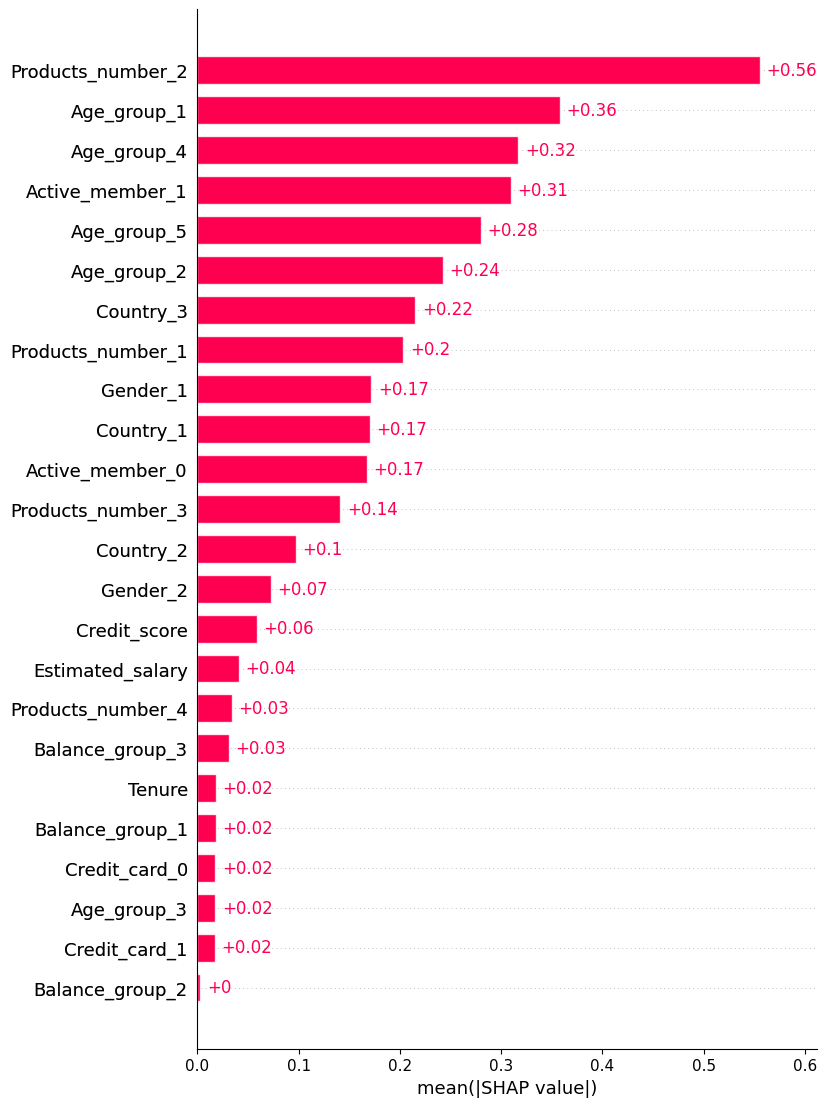

In [33]:
shap.plots.bar(shap_values, max_display=25)

### Диаграмма важности признаков на основе максимальных значений Шепли 

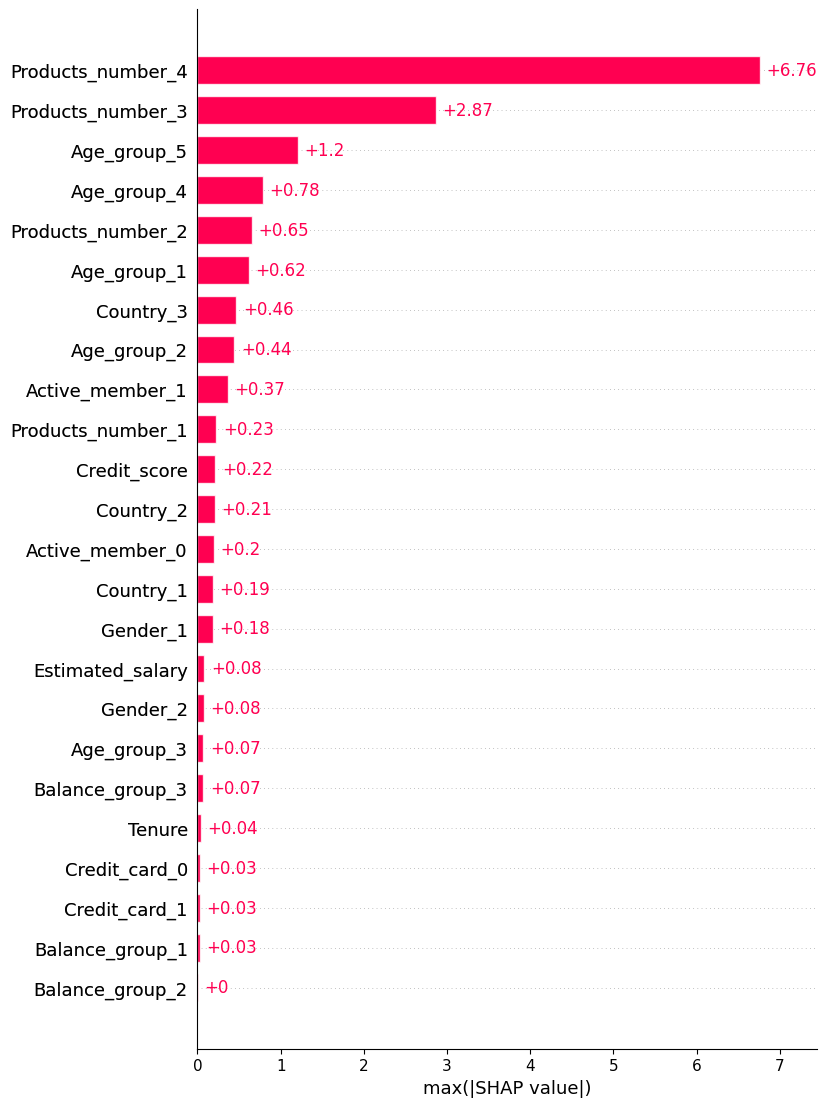

In [34]:
shap.plots.bar(shap_values.abs.max(axis=0), max_display=25)

### Диаграмма важности признаков суммарно

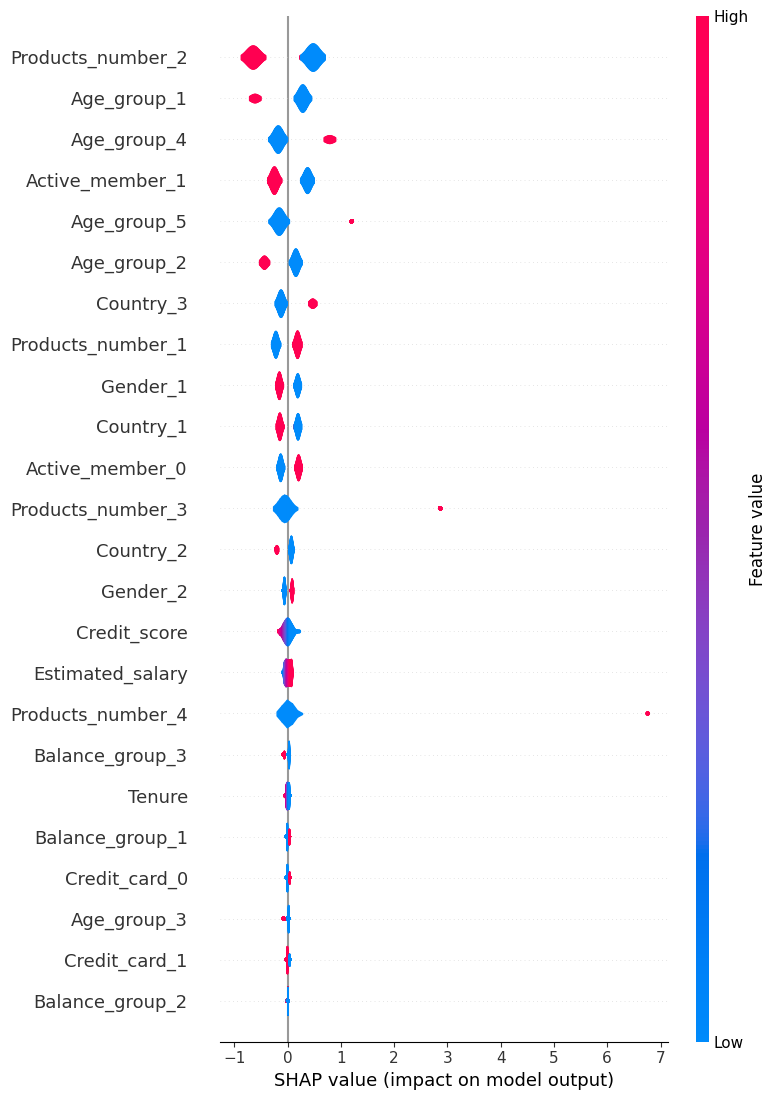

In [35]:
shap.summary_plot(shap_values=shap_values, 
                  features=data_df, 
                  max_display=25, 
                  plot_type='violin',
                  )


Эта диаграмма наиболее отчетливо показывает какие признаки и как влияют на предсказания принадлежности к классам.

Предлагаю следующую интерпретацию на основе данной диаграммы:

* Использование малого кол-ва продуктов банка (1 или 2) приводит к сохранению клиента
* В оттоке преобладали активные клиенты
* Значение предполагаемой средней зарплаты клиента не влияет на отток
* Более высокий кредитный рейтинг удерживает клиента
* Принадлежность к возрастным группам более 41 года  увеличивает вероятность оттока клиентов
* Принадлежность к возрастной группе менее 31 года - удерживает клиентов
* Пол клиента не позволяет однозначно определить влияние на отток, хотя кажется что мужчины более консервативны в этом
* Проживание в Германии повышает вероятность оттока
* Баланс (суммарно по всем группам) практически не влияет на вероятность оттока
* Клиенты с более высоким стажем использования банка - сохраняют лояльность


### Значения Шепли для конкретного семпла данных

В выпадающем списке выберите номер семпла из тестового набора данных и посмотрите на две диаграммы, показывающие вклад признаков в пердсказание результата по этому семплу

In [36]:
@interact(idx=range(len(preds)))
def display_sample_shap_plots(idx):
    pred = preds[idx]
    real = reals[idx]

    print(f"Test sample: {idx} Predicted value: {pred} " 
          f"Result class: {0 if pred < THRESHOLD else 1} True class: {real}")
    display(shap.plots.force(shap_values[idx]))
    display(shap.plots.waterfall(shap_values[idx], max_display=25))


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

### Модель только с важными признаками

Покажем что качество предсказаний модели (с сокращенным набором признаков) не пострадает

In [37]:
clf = XGBClassifier(booster='gblinear', 
                    verbosity=1,
                    eta=0.3,
                    feature_selector='cyclic',
                    updater='shotgun',
                    reg_lambda=0,
                    reg_alpha=0,
                    scale_pos_weight=scale_pos_weight,
                    random_state=100)


features = {
    'numeric': [], 
    'category': ['country', 'gender', 'age_group', 'products_number', 'active_member']
    }

model1 = create_model(clf, features)
model1

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['country', 'gender',
                                                   'age_group',
                                                   'products_number',
                                                   'active_member'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster='gblinear',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               device=None, early_stop...
                               eval_metric=None, feature_selector='cyclic',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, ...))])

In [38]:
model1, best_param1 = train_model(model1, X_train, y_train, use_gs=True)
print(f"Train model score: {model1.score(X_test, y_test)}\nBest params: {best_param1}")

Train model score: 0.86
Best params: {'classifier__eta': 0.1, 'classifier__feature_selector': 'cyclic', 'classifier__n_estimators': 50, 'classifier__scale_pos_weight': None, 'classifier__updater': 'coord_descent'}


In [39]:
score = cross_val_score(model1, X_test, y_test, cv=5).mean()
print(f"Model test CV score: {score}")

Model test CV score: 0.8540000000000001


In [ ]:
# save_model(model1)

## Inference model

In [40]:
new_data = [
    {'customer_id': 15634602,
     'credit_score':	619,
     'country': 'France',
     'gender': 'Male',
     'age':	25,
     'tenure':	5,
     'balance': 10000.00,
     'products_number': 1,
     'credit_card':	1,
     'active_member': 1,
     'estimated_salary': 98148.88,
    },
    {'customer_id': 15634605,
     'credit_score':	332,
     'country': 'Germany',
     'gender': 'Male',
     'age':	65,
     'tenure':	10,
     'balance': 100000.00,
     'products_number': 3,
     'credit_card':	1,
     'active_member': 0,
     'estimated_salary': 220000.88,
    },
]

new_data_df = DataFrame.from_dict(new_data, orient='columns')
# save new data to file
new_data_df.to_csv('data/new_customer_data.csv', index=False)

churns = predict_churn(clf_model, 
                       new_data_df, 
                       THRESHOLD)
churns

array([0, 1])